# 1. Data Preparation
Importing the data file, and preparing it to the analysis.

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('Datasets\Online_Retail.xlsx')

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Handle missing values
df['CustomerID'].fillna(method='ffill', inplace=True)
df.drop('Description', axis=1, inplace=True)
df.dropna(subset=['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice', 'Country'], inplace=True)

df.isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_6320\3802975876.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['CustomerID'].fillna(method='ffill', inplace=True)


InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
df.shape

(541909, 7)

In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country'],
      dtype='object')

---
# 2. Feature Engineering
We extract relevant features reflecting customer behavior, such as purchase history and total spending. Additional metrics like recency of purchase are calculated to capture behavior accurately.

In [7]:
# Calculate Total Spending
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Feature Aggregation
df_customer = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',    # Order frequency
    'Quantity': 'sum',         # Total quantity purchased
    'TotalAmount': 'sum',      # Total spending
    'InvoiceDate': 'max'       # Recency of purchase
}).reset_index()

# Rename columns for clarity
df_customer.columns = ['CustomerID', 'OrderFrequency', 'TotalQuantity', 'TotalSpending', 'LastPurchaseDate']

# Calculate Recency
df_customer['Recency'] = (df_customer['LastPurchaseDate'].max() - df_customer['LastPurchaseDate']).dt.days

# Display the first few rows
df_customer

,CustomerID,OrderFrequency,TotalQuantity,TotalSpending,LastPurchaseDate,Recency
0,12346.0,2,0,0.00,2011-01-18 10:17:00,325
1,12347.0,7,2458,4310.00,2011-12-07 15:52:00,1
2,12348.0,5,2745,3366.27,2011-09-25 13:13:00,74
3,12349.0,1,631,1757.55,2011-11-21 09:51:00,18
4,12350.0,1,197,334.40,2011-02-02 16:01:00,309
...,...,...,...,...,...,...
4367,18280.0,6,1815,8330.57,2011-03-07 10:15:00,277
4368,18281.0,1,54,80.82,2011-06-12 10:53:00,180
4369,18282.0,3,98,176.60,2011-12-02 11:43:00,7
4370,18283.0,16,1397,2094.88,2011-12-06 12:02:00,3


---
# 3. Dimensionality Reduction with PCA
PCA is applied to reduce the dimensionality of the feature space.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [9]:
# Standardize the features
features = ['OrderFrequency', 'TotalQuantity', 'TotalSpending', 'Recency']
x = df_customer[features]
x_scl = StandardScaler().fit_transform(x)

# Check for unnecesarry columns
pca = PCA()
pca_comp = pca.fit_transform(x_scl)
df_pca = pd.DataFrame(data=pca_comp, columns=pca.get_feature_names_out())

pca.explained_variance_ratio_

array([0.61551437, 0.24178995, 0.11991438, 0.0227813 ])

### Feature 3 and 4 seem unnecesarry at 1.9% and 12% so we will only use the first two features.

In [10]:

pca = PCA(n_components=2)
pca_comp = pca.fit_transform(x_scl)
df_pca = pd.DataFrame(data=pca_comp, columns=pca.get_feature_names_out())

# Add CustomerID for reference
df_final = pd.concat([df_pca, df_customer[['CustomerID']]], axis=1)

# Display the first few rows
df_final

,pca0,pca1,CustomerID
0,-0.948015,2.137278,12346.0
1,0.526730,-0.753458,12347.0
2,0.258581,-0.055355,12348.0
3,-0.180997,-0.674202,12349.0
4,-0.915743,2.013151,12350.0
...,...,...,...
4367,0.114946,1.919725,18280.0
4368,-0.690341,0.786378,18281.0
4369,-0.237044,-0.858156,18282.0
4370,0.662731,-0.923071,18283.0


---
# 4. Determining Optimal Number of Clusters:
We use the Elbow method to find the optimal number of clusters for K-means clustering.

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

interia 1: 14992.538017086143
interia 2: 8741.005290828361
interia 3: 5147.032915045063
interia 4: 3571.3735173763343
interia 5: 2438.485426805938
interia 6: 1897.7382148637687
interia 7: 1458.176905134674
interia 8: 1421.2451334784173
interia 9: 1023.8773137784781
interia 10: 921.6521323432085
interia 11: 742.5868063842943
interia 12: 657.0619767371163
interia 13: 607.6328474446561
interia 14: 565.2385972038539
interia 15: 495.7214493934247
interia 16: 466.483107521383
interia 17: 422.1513491242063
interia 18: 393.5699315014173
interia 19: 369.9912204219271


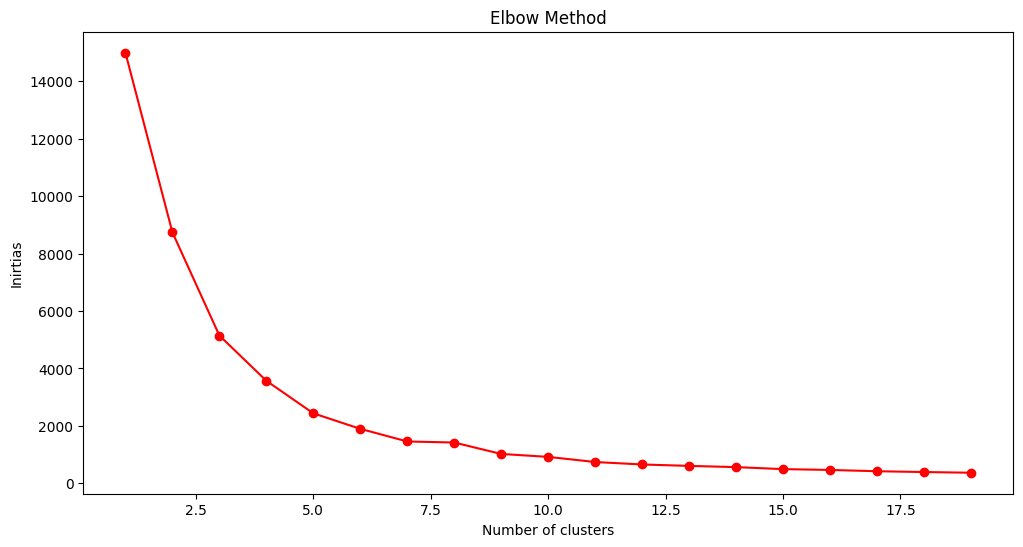

In [12]:
# Elbow Method
list_of_inirtias = []
for k in range(1, 20):
    # using seed for consistent results
    km = KMeans(n_clusters=k, random_state=29)
    km.fit(df_pca)
    list_of_inirtias.append(km.inertia_)
    print('interia ' + str(k) + ': ' + str(km.inertia_))

# Plot the elbow
plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), list_of_inirtias, 'r-o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inirtias')
plt.show()

## 3 seems to be the best k-value

---
# 5. K-means Clustering

With dimensionality reduced, K-means clustering is performed to assign each customer to a cluster based on their feature values.

In [13]:
km = KMeans(n_clusters=3, random_state=29)
km.fit(df_pca)
predictions = km.fit_predict(df_pca)

# Add cluster labels to the DataFrame
df_final['Cluster'] = predictions

# Display the first few rows
df_final

,pca0,pca1,CustomerID,Cluster
0,-0.948015,2.137278,12346.0,0
1,0.526730,-0.753458,12347.0,1
2,0.258581,-0.055355,12348.0,1
3,-0.180997,-0.674202,12349.0,1
4,-0.915743,2.013151,12350.0,0
...,...,...,...,...
4367,0.114946,1.919725,18280.0,0
4368,-0.690341,0.786378,18281.0,0
4369,-0.237044,-0.858156,18282.0,1
4370,0.662731,-0.923071,18283.0,1


---
# 6. Cluster Profiling:

Each cluster is profiled to get a better sense of what each cluster represents.

In [14]:
# Merge cluster labels with original customer data
df_cluster = pd.merge(df_customer, df_final[['CustomerID', 'Cluster']], on='CustomerID')

# Profile each cluster
prof_cluster = df_cluster.groupby('Cluster').agg({
    'OrderFrequency': 'mean',
    'TotalQuantity': 'mean',
    'TotalSpending': 'mean',
    'Recency': 'mean'
}).reset_index()

# Display cluster profiles
prof_cluster

,Cluster,OrderFrequency,TotalQuantity,TotalSpending,Recency
0,0,2.146037,284.412289,534.716288,243.499555
1,1,6.687713,1184.177035,2259.385386,38.531105
2,2,104.555556,57276.611111,102621.520000,6.111111


---
# 7. Visualization:

Using a scatter plot, we visualize the data to see how the cluster are represented on a plot.

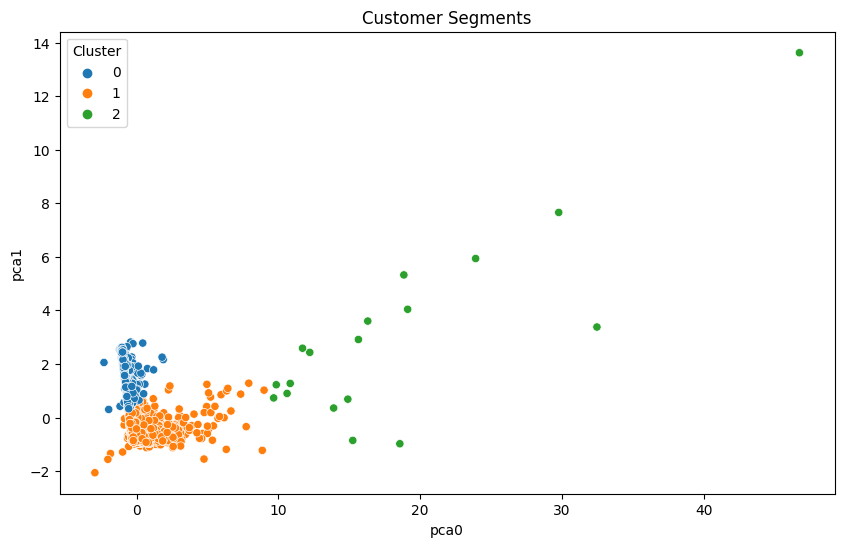

In [15]:
import seaborn as sns

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='pca0', y='pca1', hue='Cluster', palette='tab10')
plt.title('Customer Segments')
plt.show()

---
# 8. Evaluation:

Clustering quality is determined using appropriate silhouette score and within-cluster sum of squares.

In [16]:
from sklearn.metrics import silhouette_score

In [17]:
# Calculate silhouette score
sil_score = silhouette_score(df_pca, df_final['Cluster'])
print(f'Silhouette Score: {sil_score}')

distances = km.transform(df_pca)
squared_distances = distances**2
wcss = squared_distances.sum(axis=1)
total_wcss = wcss.sum()

print("Total within-cluster sum of squares (WCSS):", total_wcss)

Silhouette Score: 0.5871564522722428
Total within-cluster sum of squares (WCSS): 1568937.3069614987


### 59% is a decent Silohouette score, and ~1550000 is relatively okay with the amount and spread of the data.

---
## Extra: Remapping Clusters into proper named categories

We remap the clusters into a new column called 'Buyer type' to properly categorize the clusters instead of leaving them at 0, 1, 2.

In [18]:
# Remap the Cluster column to a more appropriate BuyerType column
cluster_mapping = {
    0: 'High, Frequent',
    1: 'Moderate, Infrequent',
    2: 'Low, Frequent'
}

df_cluster['BuyerType'] = df_cluster['Cluster'].map(cluster_mapping)


# Move the BuyerType column to the second column
cols_cluster = [df_cluster.columns[0]] + ['BuyerType'] + [col for col in df_cluster.columns if col not in [df_cluster.columns[0], 'BuyerType']]
df_cluster = df_cluster[cols_cluster]

# Remove the old Cluster column
df_cluster.drop('Cluster', axis=1, inplace=True)

df_cluster

,CustomerID,BuyerType,OrderFrequency,TotalQuantity,TotalSpending,LastPurchaseDate,Recency
0,12346.0,"High, Frequent",2,0,0.00,2011-01-18 10:17:00,325
1,12347.0,"Moderate, Infrequent",7,2458,4310.00,2011-12-07 15:52:00,1
2,12348.0,"Moderate, Infrequent",5,2745,3366.27,2011-09-25 13:13:00,74
3,12349.0,"Moderate, Infrequent",1,631,1757.55,2011-11-21 09:51:00,18
4,12350.0,"High, Frequent",1,197,334.40,2011-02-02 16:01:00,309
...,...,...,...,...,...,...,...
4367,18280.0,"High, Frequent",6,1815,8330.57,2011-03-07 10:15:00,277
4368,18281.0,"High, Frequent",1,54,80.82,2011-06-12 10:53:00,180
4369,18282.0,"Moderate, Infrequent",3,98,176.60,2011-12-02 11:43:00,7
4370,18283.0,"Moderate, Infrequent",16,1397,2094.88,2011-12-06 12:02:00,3


# 9. Personalization and Recommendations

Tailor personalized marketing strategies and recommendations for each Buyer Type.

In [19]:
# Add a MarketingStrategy to each type of buyer.
def marketing_strategy(cluster):
    if cluster == 'High, Frequent':
        return 'Exclusive deals, Loyalty programs'
    elif cluster == 'Moderate, Infrequent':
        return 'Marketing campaigns, Seasonal Promotions'
    elif cluster == 'Low, Frequent':
        return 'Bundles, Frequent discounts'

# Apply marketing strategy to each customer segment
df_cluster['MarketingStrategy'] = df_cluster['BuyerType'].apply(marketing_strategy)


# Display marketing strategies for the first few customers
df_cluster

,CustomerID,BuyerType,OrderFrequency,TotalQuantity,TotalSpending,LastPurchaseDate,Recency,MarketingStrategy
0,12346.0,"High, Frequent",2,0,0.00,2011-01-18 10:17:00,325,"Exclusive deals, Loyalty programs"
1,12347.0,"Moderate, Infrequent",7,2458,4310.00,2011-12-07 15:52:00,1,"Marketing campaigns, Seasonal Promotions"
2,12348.0,"Moderate, Infrequent",5,2745,3366.27,2011-09-25 13:13:00,74,"Marketing campaigns, Seasonal Promotions"
3,12349.0,"Moderate, Infrequent",1,631,1757.55,2011-11-21 09:51:00,18,"Marketing campaigns, Seasonal Promotions"
4,12350.0,"High, Frequent",1,197,334.40,2011-02-02 16:01:00,309,"Exclusive deals, Loyalty programs"
...,...,...,...,...,...,...,...,...
4367,18280.0,"High, Frequent",6,1815,8330.57,2011-03-07 10:15:00,277,"Exclusive deals, Loyalty programs"
4368,18281.0,"High, Frequent",1,54,80.82,2011-06-12 10:53:00,180,"Exclusive deals, Loyalty programs"
4369,18282.0,"Moderate, Infrequent",3,98,176.60,2011-12-02 11:43:00,7,"Marketing campaigns, Seasonal Promotions"
4370,18283.0,"Moderate, Infrequent",16,1397,2094.88,2011-12-06 12:02:00,3,"Marketing campaigns, Seasonal Promotions"


# 10. Interpretation and Insights
The outcomes of segmentation are interpreted, providing valuable insights. Implications for the e-commerce business, including targeted marketing, and customer retention strategies, are discussed based on the identified customer clusters. With all the valuable data incorporated into the final clustered dataframe for ease of access.